In [46]:
import sys
import os
import numpy as np
import cv2
import open3d as o3d
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import gtsam
from scipy.spatial import cKDTree
from pr2_utils import bresenham2D


# part1: Encoder and IMU data

load data

In [50]:
dataset = 20

with np.load("../data/Encoders%d.npz"%dataset) as data:
    encoder_counts = data["counts"] # 4 x n encoder counts
    encoder_stamps = data["time_stamps"] # encoder time stamps

with np.load("../data/Hokuyo%d.npz"%dataset) as data:
    lidar_angle_min = data["angle_min"] # start angle of the scan [rad]
    lidar_angle_max = data["angle_max"] # end angle of the scan [rad]
    lidar_angle_increment = data["angle_increment"] # angular distance between measurements [rad]
    lidar_range_min = data["range_min"] # minimum range value [m]
    lidar_range_max = data["range_max"] # maximum range value [m]
    lidar_ranges = data["ranges"]       # range data [m] (Note: values < range_min or > range_max should be discarded)
    lidar_stamsp = data["time_stamps"]  # acquisition times of the lidar scans

with np.load("../data/Imu%d.npz"%dataset) as data:
    imu_angular_velocity = data["angular_velocity"] # angular velocity in rad/sec
    imu_linear_acceleration = data["linear_acceleration"] # accelerations in gs (gravity acceleration scaling)
    imu_stamps = data["time_stamps"]  # acquisition times of the imu measurements

with np.load("../data/Kinect%d.npz"%dataset) as data:
    disp_stamps = data["disparity_time_stamps"] # acquisition times of the disparity images
    rgb_stamps = data["rgb_time_stamps"] # acquisition times of the rgb images

Distance and velocity calculate

In [51]:
# wheels distance
# [FR, FL, RR, RL]
deltaTime = np.zeros(encoder_stamps.shape[0] - 1)
for i in range(encoder_stamps.shape[0] - 1):
    deltaTime[i] = encoder_stamps[i+1] - encoder_stamps[i]

carDistance = np.zeros(encoder_counts.shape[1] - 1)
for i in range(encoder_counts.shape[1] - 1):
    # right wheel distance
    rightWheel = (encoder_counts[0, i] + encoder_counts[2, i]) / 2 * 0.0022
    # left wheel distance
    leftWheel = (encoder_counts[1, i] + encoder_counts[3, i]) / 2 * 0.0022
    carDistance[i] = (rightWheel + leftWheel) / 2

carVelocity = carDistance / deltaTime


Angular velocity

In [52]:
# time synchronize
angularVelocity = np.zeros(carVelocity.shape)
imuIndex = 0
encoderIndex = 0
while imu_stamps[0] > encoder_stamps[encoderIndex]:
    encoderIndex += 1

for i in range(encoderIndex, encoder_stamps.shape[0] - 1):
    average = 0
    count = 0
    while imu_stamps[imuIndex] <  encoder_stamps[i+1]:
        average += imu_angular_velocity[2][imuIndex]
        count += 1
        if imuIndex < imu_stamps.shape[0] - 1:
            imuIndex += 1
        else:
            break
    if count == 0:
        angularVelocity[i] = imu_angular_velocity[2][imuIndex-1]
    else:
        angularVelocity[i] = average / count 
    
# print(angularVelocity)


Odometry predict

(4956, 3)


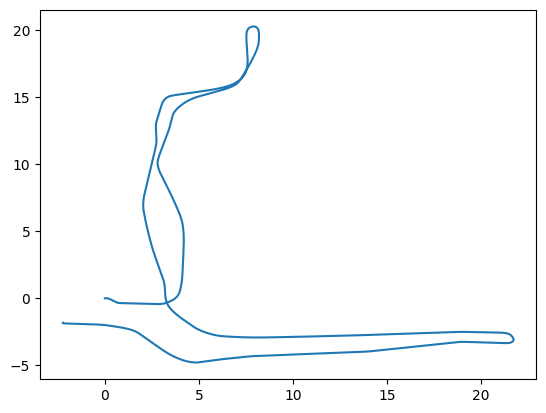

In [53]:
state = np.zeros((encoder_counts.shape[1], 3))

for i in range(encoder_counts.shape[1] - 1):
    angle = state[i, 2]
    averageAngular = angularVelocity[i] * deltaTime[i] / 2
    state[i+1] = state[i] + deltaTime[i] * np.array([carVelocity[i] * np.sinc(averageAngular) * np.cos(angle + averageAngular), carVelocity[i] * np.sinc(averageAngular) * np.sin(angle + averageAngular), angularVelocity[i]])
print(state.shape)
plt.figure()
plt.plot(state[:,0], state[:,1])


# part 2

In [ ]:
# python ICP warm up 

os.chdir("./icp_warm_up/")
%run -i ./test_icp.py
os.chdir("../")

(1081, 4962)


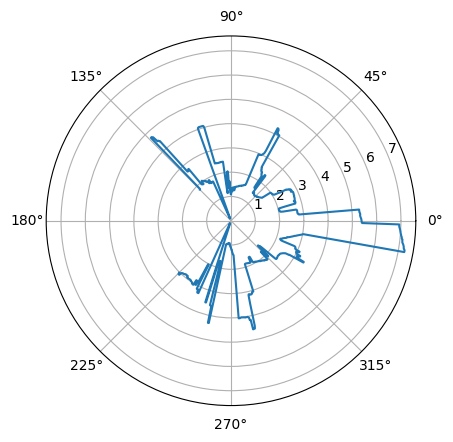

In [54]:
# lidar data check
# lidar data has 1081 points per scan, and shape[1] of lidar_ranges is hot many scan
print(lidar_ranges.shape)
angles = np.arange(lidar_angle_min, lidar_angle_max + lidar_angle_increment - 1e-7, lidar_angle_increment)
ranges = lidar_ranges[:, 4700]
plt.figure()
ax = plt.subplot(111, projection='polar')
ax.plot(angles, ranges)


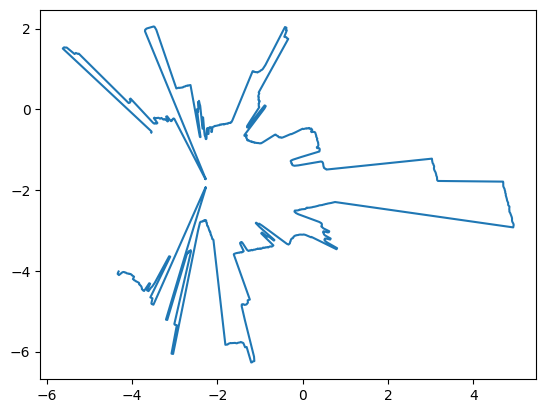

In [55]:
# synchronize
startState = 0
for i in range(encoder_stamps.shape[0]):
    if lidar_stamsp[0] < encoder_stamps[i]:
        startState = max(i - 1, 0)
        break
timeRatio = max(1, int((lidar_stamsp[1] - lidar_stamsp[0]) / (encoder_stamps[1] - encoder_stamps[0])))

# transform lidar data to world frame
angles = np.arange(lidar_angle_min, lidar_angle_max + lidar_angle_increment - 1e-7, lidar_angle_increment)
lidar_robot_frame = np.zeros((int((min(state.shape[0], lidar_ranges.shape[1]) - startState) / timeRatio), lidar_ranges.shape[0], 3))

for i in range(startState, lidar_robot_frame.shape[0], timeRatio):
    lidar_robot_frame[i, :, 0] = lidar_ranges[:, i] * np.cos(angles + state[i, 2]) + state[i, 0]
    lidar_robot_frame[i, :, 1] = lidar_ranges[:, i] * np.sin(angles + state[i, 2]) + state[i, 1]

plt.plot(lidar_robot_frame[4700, :, 0], lidar_robot_frame[4700, :, 1])


In [56]:
def rotationZ(angle):
    return np.array([[np.cos(angle), -np.sin(angle), 0],
                     [np.sin(angle), np.cos(angle), 0],
                     [0, 0, 1]])

def remap(target, target_prox):
    mapping = np.arange(target_prox.shape[0])
    # build KD tree for quicker search
    target_KDtree = cKDTree(target)
    for i in range(target_prox.shape[0]):
        _, mapping[i] = target_KDtree.query(target_prox[i])

    return mapping

def ICP(source, target, distance, iters = 5, z_angle = 0, p = None):
    mean_source = np.mean(source, axis=0)
    delta_source = source - mean_source
    mean_target = np.mean(target, axis=0)
    delta_target = target - mean_target

    weight = 1 / distance
    # Too far point set to 0
    weight[weight < 1 / 8] = 0
    
    # try to initialize different rotation matrix
    rotation_matrix = rotationZ(z_angle)
    if (p == None):
        p = np.zeros(3)

    for iter in range(iters):
        # map to closest point
        target_prox = (rotation_matrix.T @ (source - p).T).T
        mapping = remap(target, target_prox)

        # calculate dist of point cloud
        dist = 0
        for i in range(source.shape[0]):
            dist = dist + np.linalg.norm(target[mapping[i]] - target_prox[i])
        # print(f"iter: {iter}, dist = {dist}")

        # iterate next rotation matrix and p
        Q = np.zeros((3,3))
        for j in range(source.shape[0]):
            Q += weight[j] * delta_source[j].reshape((3, 1)) @ delta_target[mapping[j]].reshape((1, 3))
        U, _, V = np.linalg.svd(Q)
        rotation_matrix = U @ V
        if np.linalg.det(rotation_matrix) < 0.0:
            V[-1, :] *= -1
            rotation_matrix = U @ V
        p = mean_source - (rotation_matrix @ mean_target)

    pose = np.eye(4)
    pose[:3,:3] = rotation_matrix.T
    pose[:3, -1] = -(rotation_matrix.T @ p)
    # print(f"Pose: \n{pose}")
    return pose

In [58]:
stateICP = np.zeros((state.shape[0], 3))
# ICP (data * 3)

for i in range(lidar_robot_frame.shape[0] - 1):
    distance = np.linalg.norm(lidar_robot_frame[i] - state[i, 0], axis=1)
    pose = ICP(lidar_robot_frame[i], lidar_robot_frame[i+1], distance, iters=5, z_angle=(state[i+1, 2] - state[i, 2]), p=[state[i+1, 0] - state[i, 0], state[i+1, 1] - state[i, 1], 0])
    rotationMatrix = pose[0:3, 0:3]
    p = pose[0:3, -1]
    stateICP[i+1] = rotationMatrix @ stateICP[i] + p

np.save("stateICP_dataset_" + str(dataset) + ".npy", stateICP)

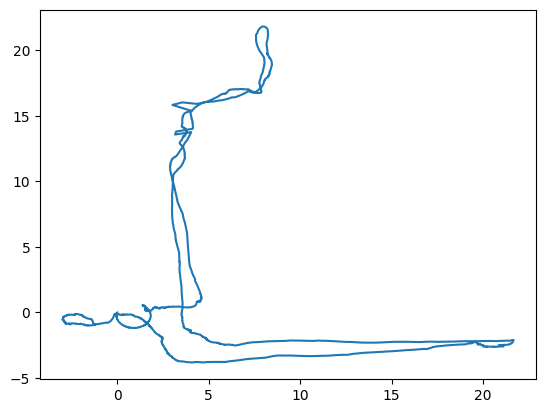

In [59]:
stateICP = np.load("stateICP_dataset_" + str(dataset) + ".npy")
plt.plot(stateICP[:, 0], stateICP[:, 1])
# print(stateICP)

# part 3

In [77]:
def plot_map(mapdata, cmap="binary"):
  plt.imshow(mapdata.T, origin="lower", cmap=cmap)

def grid_map(lidar_robot_frame, state):
  # Initialize a grid map
  MAP = {}
  MAP['res'] = np.array([0.1, 0.1])    # meters
  MAP['min'] = np.array([-10.0, -10.0])  # meters
  MAP['max'] = np.array([30.0, 30.0])    # meters
  MAP['size'] = np.ceil((MAP['max'] - MAP['min']) / MAP['res']).astype(int)
  isEven = MAP['size']%2==0
  MAP['size'][isEven] = MAP['size'][isEven]+1 # Make sure that the map has an odd size so that the origin is in the center cell
  MAP['map'] = np.zeros(MAP['size'])

  # Convert from meters to cells
  
  for scan in range(lidar_robot_frame.shape[0]):

    startPoint = np.floor((state[scan] - MAP['min']) / MAP['res']).astype(int)
    endPoint = np.floor((lidar_robot_frame[scan, :, :2] - MAP['min']) / MAP['res']).astype(int)
    for i in range(lidar_robot_frame.shape[1]):
      dist = np.linalg.norm(endPoint[i, :2] - startPoint[:2])
      if dist > 25 or dist < 2:
        continue
      path = bresenham2D(startPoint[0], startPoint[1], endPoint[i, 0], endPoint[i, 1]).astype(int)

      # Insert valid points in the map
      valid1 = np.all((path.T >= 0) & (path.T < MAP['size']),axis=1)
      valid2 = (MAP['map'][tuple(path.T[valid1].T)] > -20)
      MAP['map'][tuple(path.T[valid1 & valid2].T)] -= np.log(4)  

      valid1 = np.all((endPoint >= 0) & (endPoint < MAP['size']),axis=1)
      valid2 = (MAP['map'][tuple(endPoint[valid1].T)] < 20)
      try:
        MAP['map'][tuple(endPoint[valid1 & valid2].T)] += 2 * np.log(4)
      except:
        pass
        # print(scan, i)
  return MAP
  

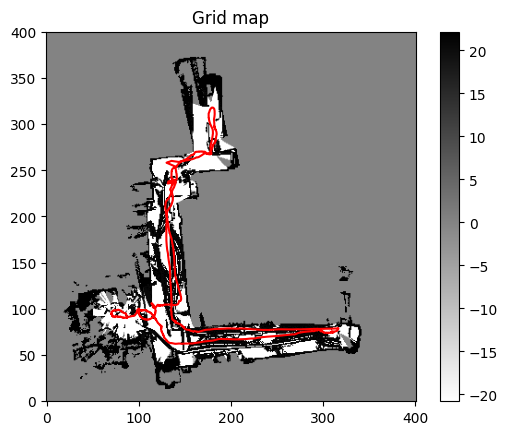

In [61]:
MAP = grid_map(lidar_robot_frame[:, :, :], stateICP[:, :2])
# Plot the grid map
fig2 = plt.figure()
plot_map(MAP['map'], cmap='binary')
plt.plot(stateICP[:,0] * 10 + 100, stateICP[:,1] * 10 + 100, c='r')
plt.title('Grid map')
plt.colorbar()
plt.show(block=True)

In [62]:
def image2pointClooud(disp_img, rgb_img, state):
    height, width = disp_img.shape

    dd = np.array(-0.00304 * disp_img + 3.31)
    depth = 1.03 / dd

    mesh = np.meshgrid(np.arange(0, height), np.arange(0, width), indexing='ij')  
    i_idxs = mesh[0].flatten()
    j_idxs = mesh[1].flatten()

    rgb_i = np.array((526.37 * i_idxs + 19276 - 7877.07 * dd.flatten()) / 585.051, dtype=np.int32)  # force int for indexing
    rgb_j = np.array((526.37 * j_idxs + 16662) / 585.051, dtype=np.int32)

    # Clip idx out of bound
    rgb_i = np.clip(rgb_i, 0, height - 1)
    rgb_j = np.clip(rgb_j, 0, width - 1)

    colors = rgb_img[rgb_i, rgb_j]

    uv1 = np.vstack([j_idxs, i_idxs, np.ones_like(i_idxs)])
    K = np.array([[585.05, 0, 242.94],
                  [0, 585.05, 315.84],
                  [0, 0, 1]])

    # project images to 3d points (z = Kpi * oRr(robotic to optical) * R' * (m - p))
    # m = z * inv(Kpi) * rOo * R + p
    points = depth.flatten() * (np.linalg.inv(K) @ uv1)

    oRr = np.array([[0, -1, 0],
                    [0, 0, -1],
                    [1, 0, 0]])
    
    points = oRr.T @ points
    rotationMatrix = rotationZ(state[2])
    p = np.array([state[0], state[1], 0])
    points = (rotationMatrix @ points).T + p
    return points, colors


In [63]:
def rgb_map(rgbState, odometry):
  # Initialize a grid map
  MAP = {}
  MAP['res'] = np.array([0.1, 0.1])    # meters
  MAP['min'] = np.array([-10.0, -10.0])  # meters
  MAP['max'] = np.array([30.0, 30.0])    # meters
  MAP['size'] = np.ceil((MAP['max'] - MAP['min']) / MAP['res']).astype(int)
  isEven = MAP['size']%2==0
  MAP['size'][isEven] = MAP['size'][isEven]+1 # Make sure that the map has an odd size so that the origin is in the center cell
  MAP['map'] = np.zeros((MAP['size'][0], MAP['size'][1], 3))

  for i in range(1, rgbState.shape[0]+1):
    disp_img = cv2.imread("../dataRGBD/Disparity20/disparity20_" + str(i) + ".png", cv2.IMREAD_UNCHANGED)
    bgr_img = cv2.imread("../dataRGBD/RGB20/rgb20_" + str(i) + ".png")
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    points, colors = image2pointClooud(disp_img, rgb_img, odometry[int(rgbState[i-1])])

    z = points[:, 2]
    mask = (z < 1e-3)
    indices = np.where(mask)
    points = points[indices]
    colors = colors[indices]
  
    point_grid = np.floor((points[:,:2] - MAP['min']) / MAP['res']).astype(int)
    # Insert valid points in the map
    MAP['map'][tuple(point_grid.T)] = colors/255
  
  return MAP

In [64]:
# synchronize image time (based on rgb_stamps)
rgbState = np.zeros(rgb_stamps.shape[0])
encoderIndex = 0
for i in range(rgb_stamps.shape[0]):
    while rgb_stamps[i] > encoder_stamps[encoderIndex]:
        if (encoderIndex < encoder_stamps.shape[0] - 1):
            encoderIndex += 1
        else:
            break
    rgbState[i] = encoderIndex - 1


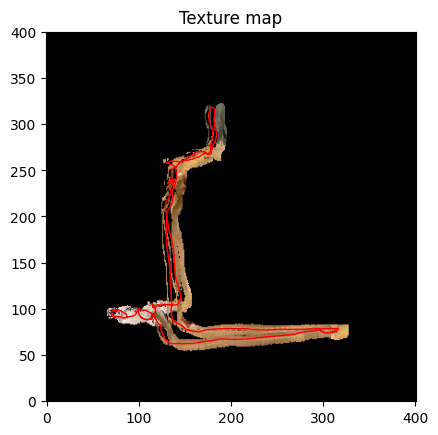

In [65]:
# plotting texture mapping
output = rgb_map(rgbState, stateICP)
plt.imshow(np.transpose(output['map'], axes=(1,0,2)), origin="lower")
plt.title('Texture map')
plt.plot(stateICP[:,0] * 10 + 100, stateICP[:,1] * 10 + 100, c='r', linewidth=1)

# Part 4: GTSAM

In [66]:
# method (a): fixed-interval loop closure
interval = 20
graph = gtsam.NonlinearFactorGraph()
initial_state = gtsam.Values()
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(0, 0, 0))

# setting factor graph
graph.add(gtsam.PriorFactorPose2(1, gtsam.Pose2(0, 0, 0), ODOMETRY_NOISE))
for i in range(stateICP.shape[0] - 1):
    graph.add(gtsam.BetweenFactorPose2(i+1, i+2, gtsam.Pose2(stateICP[i+1, 0] - stateICP[i, 0], stateICP[i+1, 1] - stateICP[i, 1], stateICP[i+1, 2] - stateICP[i, 2]), ODOMETRY_NOISE))
    if i % interval == 0 and i > 0:
        pose = ICP(lidar_robot_frame[i-interval], lidar_robot_frame[i], np.ones(stateICP.shape[0]), iters=5, z_angle=(stateICP[i, 2] - state[i-50, 2]))
        rotationMatrix = pose[0:3, 0:3]
        p = pose[0:3, -1]
        diff = stateICP[i] - (rotationMatrix @ stateICP[i-interval] + p)
        graph.add(gtsam.BetweenFactorPose2(i-interval+1, i+1, gtsam.Pose2(diff[0], diff[1], diff[2]), ODOMETRY_NOISE))
    
    initial_state.insert(i+1, gtsam.Pose2(stateICP[i, 0], stateICP[i, 1], stateICP[i, 2]))
initial_state.insert(stateICP.shape[0], gtsam.Pose2(stateICP[-1]))

optimizer = gtsam.GaussNewtonOptimizer(graph, initial_state)

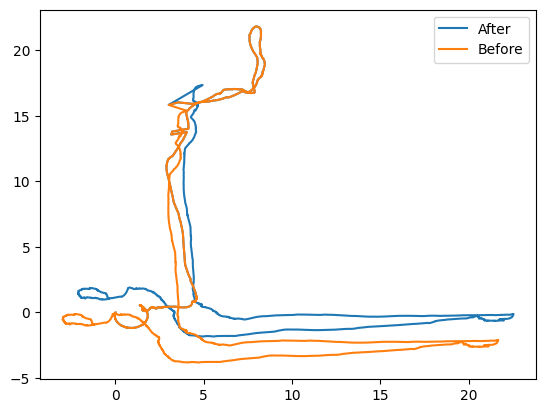

In [67]:
result = optimizer.optimize()
odometry = np.zeros(state.shape)
for i in range(odometry.shape[0]):
    odometry[i] = [result.atPose2(i+1).x(), result.atPose2(i+1).y(), result.atPose2(i+1).theta()]

plt.plot(odometry[:, 0], odometry[:, 1])
plt.plot(stateICP[:, 0], stateICP[:, 1])
plt.legend(["After", "Before"])

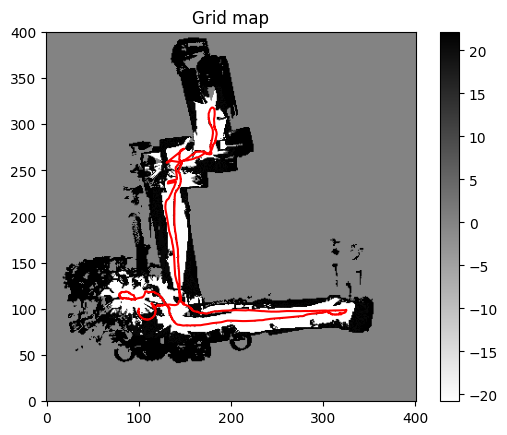

In [81]:
angles = np.arange(lidar_angle_min, lidar_angle_max + lidar_angle_increment - 1e-7, lidar_angle_increment)
lidar_robot_frame = np.zeros((int((min(state.shape[0], lidar_ranges.shape[1]) - startState) / timeRatio), lidar_ranges.shape[0], 3))
for i in range(startState, lidar_robot_frame.shape[0], timeRatio):
    lidar_robot_frame[i, :, 0] = lidar_ranges[:, i] * np.cos(angles + state[i, 2]) + odometry[i, 0]  # The orientation for looks weird if I use data modified by GTSAM 
    lidar_robot_frame[i, :, 1] = lidar_ranges[:, i] * np.sin(angles + state[i, 2]) + odometry[i, 1]
MAP = grid_map(lidar_robot_frame[:, :, :], odometry[:, :2])
# Plot the grid map
fig2 = plt.figure()
plot_map(MAP['map'], cmap='binary')
plt.plot(odometry[:,0] * 10 + 100, odometry[:,1] * 10 + 100, c='r')
plt.title('Grid map')
plt.colorbar()
plt.show(block=True)

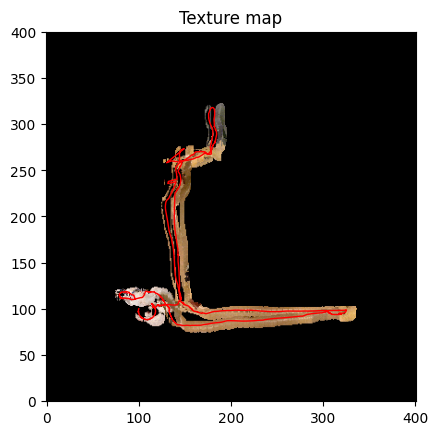

In [82]:
output = rgb_map(rgbState, odometry)
plt.imshow(np.transpose(output['map'], axes=(1,0,2)), origin="lower")
plt.title('Texture map')
plt.plot(odometry[:,0] * 10 + 100, odometry[:,1] * 10 + 100, c='r', linewidth=1)

In [83]:
# Proximity-based loop
# setting factor graph
graph = gtsam.NonlinearFactorGraph()
initial_state = gtsam.Values()
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(0, 0, 0))
loopCount = 0
graph.add(gtsam.PriorFactorPose2(1, gtsam.Pose2(0, 0, 0), ODOMETRY_NOISE))
for i in range(stateICP.shape[0] - 1):
    for j in range(i+1, lidar_robot_frame.shape[0], 5): # the step is to speed up the computation
        if j == i + 1:
            graph.add(gtsam.BetweenFactorPose2(i+1, i+2, gtsam.Pose2(stateICP[i+1, 0] - stateICP[i, 0], stateICP[i+1, 1] - stateICP[i, 1], stateICP[i+1, 2] - stateICP[i, 2]), ODOMETRY_NOISE))
        elif j - i > 250 and np.linalg.norm(stateICP[i] - stateICP[j]) < 0.015:
            pose = ICP(lidar_robot_frame[j], lidar_robot_frame[i], np.ones(stateICP.shape[0]), iters=5, z_angle=(stateICP[j, 2] - state[i, 2]))
            rotationMatrix = pose[0:3, 0:3]
            p = pose[0:3, -1]
            diff = stateICP[j] - (rotationMatrix @ stateICP[i] + p)
            graph.add(gtsam.BetweenFactorPose2(i+1, j+1, gtsam.Pose2(diff[0], diff[1], diff[2]), ODOMETRY_NOISE))
            loopCount += 1
            
    
    initial_state.insert(i+1, gtsam.Pose2(stateICP[i, 0], stateICP[i, 1], stateICP[i, 2]))
initial_state.insert(stateICP.shape[0], gtsam.Pose2(stateICP[-1]))

optimizer = gtsam.GaussNewtonOptimizer(graph, initial_state)

492


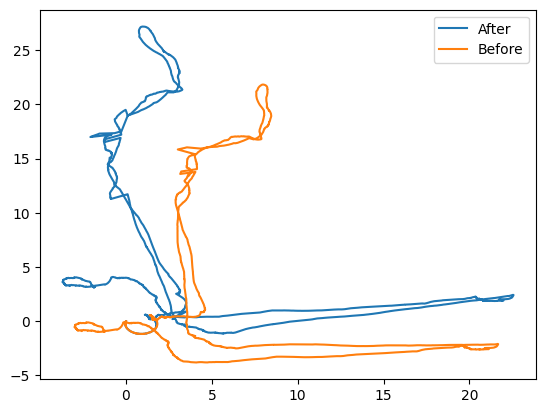

In [84]:
result = optimizer.optimize()
odometry = np.zeros(state.shape)
for i in range(odometry.shape[0]):
    odometry[i] = [result.atPose2(i+1).x(), result.atPose2(i+1).y(), result.atPose2(i+1).theta()]

print(loopCount)
plt.plot(odometry[:, 0], odometry[:, 1])
plt.plot(stateICP[:, 0], stateICP[:, 1])
plt.legend(["After", "Before"])

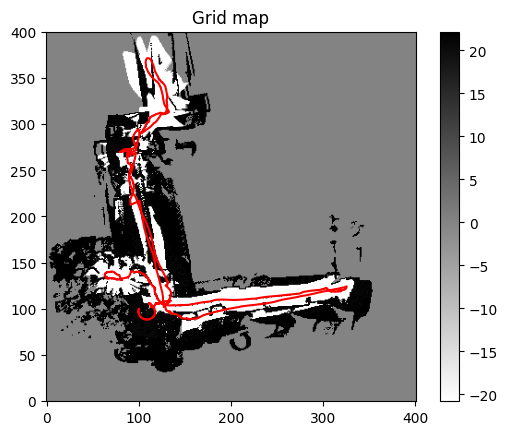

In [ ]:
angles = np.arange(lidar_angle_min, lidar_angle_max + lidar_angle_increment - 1e-7, lidar_angle_increment)
lidar_robot_frame = np.zeros((int((min(state.shape[0], lidar_ranges.shape[1]) - startState) / timeRatio), lidar_ranges.shape[0], 3))
for i in range(startState, lidar_robot_frame.shape[0], timeRatio):
    lidar_robot_frame[i, :, 0] = lidar_ranges[:, i] * np.cos(angles + state[i, 2]) + odometry[i, 0]  # The orientation for looks weird if I use data modified by GTSAM 
    lidar_robot_frame[i, :, 1] = lidar_ranges[:, i] * np.sin(angles + state[i, 2]) + odometry[i, 1]
MAP = grid_map(lidar_robot_frame[:, :, :], odometry[:, :2])
Plot the grid map
fig2 = plt.figure()
plot_map(MAP['map'], cmap='binary')
plt.plot(odometry[:,0] * 10 + 100, odometry[:,1] * 10 + 100, c='r')
plt.title('Grid map')
plt.colorbar()
plt.show(block=True)

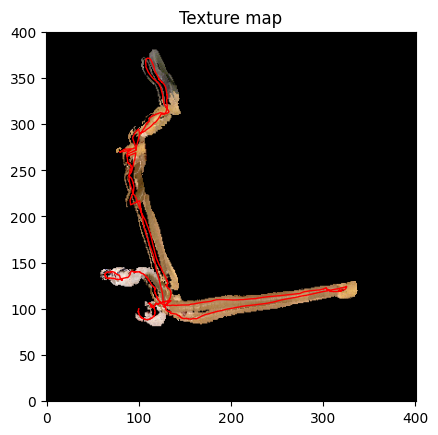

In [87]:
output = rgb_map(rgbState, odometry)
plt.imshow(np.transpose(output['map'], axes=(1,0,2)), origin="lower")
plt.title('Texture map')
plt.plot(odometry[:,0] * 10 + 100, odometry[:,1] * 10 + 100, c='r', linewidth=1)